### Importing Libraries 


In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

#Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#Image handling
from PIL import Image
import cv2

#progress bars
from tqdm import tqdm


### Data Loading & Exploration


In [ ]:
# Paths
train_dir = "Data/chest_xray/train"
val_dir = "Data/chest_xray/val"
test_dir = "Data/chest_xray/test"

# Count images per class
for category in ["NORMAL", "PNEUMONIA"]:
    print(f"[{category}] train images:", len(os.listdir(os.path.join(train_dir, category))))
    print(f"[{category}] val images:", len(os.listdir(os.path.join(val_dir, category))))
    print(f"[{category}] test images:", len(os.listdir(os.path.join(test_dir, category))))

[NORMAL] train images: 1341
[NORMAL] val images: 8
[NORMAL] test images: 234
[PNEUMONIA] train images: 3875
[PNEUMONIA] val images: 8
[PNEUMONIA] test images: 390


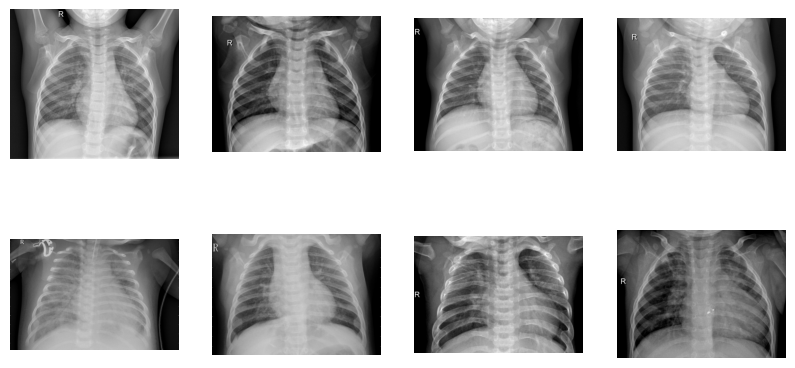

In [7]:
# Visualize samples
import matplotlib.image as mpimg
sample_normal = os.listdir(os.path.join(train_dir, "NORMAL"))[:4]
sample_pneumonia = os.listdir(os.path.join(train_dir, "PNEUMONIA"))[:4]

plt.figure(figsize=(10,5))
for i, img_name in enumerate(sample_normal + sample_pneumonia):
    plt.subplot(2,4,i+1)
    img_path = os.path.join(train_dir, "NORMAL" if i<4 else "PNEUMONIA", img_name)
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()


#### Data Preprocessing & Augmentation


In [8]:
IMG_SIZE = (150,150) 
BATCH_SIZE = 32

In [9]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Model Building (Basic CNN)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\user\OneDrive\Documents\Desktop\ChestXRay\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\user\AppData\Local\Temp\ipykernel_19916\3632448541.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step


#### Model Training

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 414ms/step - accuracy: 0.9515 - loss: 0.1287 - val_accuracy: 0.8125 - val_loss: 0.3205
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 673ms/step - accuracy: 0.9496 - loss: 0.1248 - val_accuracy: 0.7500 - val_loss: 0.4438
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1528s 9s/step - accuracy: 0.9534 - loss: 0.1148 - val_accuracy: 0.8750 - val_loss: 0.3458
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 305s 739ms/step - accuracy: 0.9525 - loss: 0.1213 - val_accuracy: 0.8750 - val_loss: 0.3240
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 1591s 10s/step - accuracy: 0.9521 - loss: 0.1212 - val_accuracy: 0.6875 - val_loss: 0.4742
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 697ms/step - accuracy: 0.9551 - loss: 0.1213 - val_accuracy: 0.8125 - val_loss: 0.3438
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9571 - loss: 0.1123 - val_accuracy: 0.8750 - val_loss: 0.3212
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 693ms/step - accuracy: 0.9544 - loss: 

##### Evaluation & Visualization

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [15]:
# Evaluate on test set
test_gen.reset()
preds = model.predict(test_gen)
pred_labels = np.where(preds>0.5, 1, 0)

print(classification_report(test_gen.classes, pred_labels, target_names=['NORMAL','PNEUMONIA']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 
              precision    recall  f1-score   support

      NORMAL       0.89      0.80      0.84       234
   PNEUMONIA       0.89      0.94      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



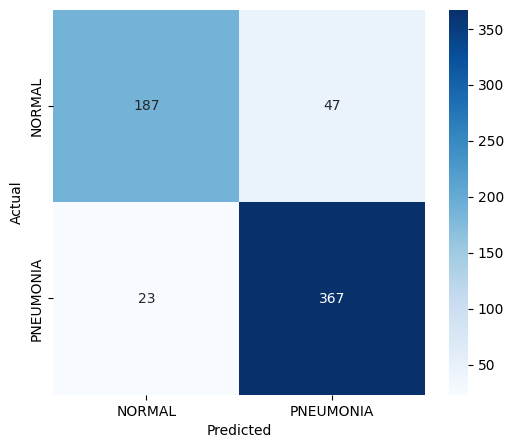

In [16]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL','PNEUMONIA'], yticklabels=['NORMAL','PNEUMONIA'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

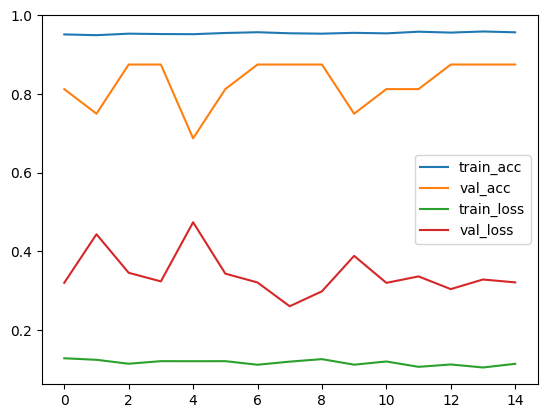

In [17]:
# Training curves
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
